In [3]:
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


# 解压数据

In [4]:
def uncompress_features_labels(file):
    features=[]
    labels=[]
    
    with ZipFile(file) as zipf:
        filename_pbar=tqdm(zipf.namelist(),unit='files')
    
        for filename in filename_pbar:
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image=Image.open(image_file)   #读取一张图片
                    image.load()                   #？？？
                 # Load image data as 1 dimensional array
                    feature=np.array(image,dtype=np.float32).flatten()
                label=os.path.split(filename)[1][0]
                
                features.append(feature)
                labels.append(label)
                
    return np.array(features),np.array(labels)

In [5]:
train_features, train_labels = uncompress_features_labels('notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('notMNIST_test.zip')
print('All features and labels uncompressed.')

100%|███████████████████████████████████████████████████████████████████████| 10001/10001 [00:01<00:00, 6342.11files/s]


All features and labels uncompressed.


## 数据预处理

In [6]:
encoder=LabelBinarizer()  #sklearn.preprocessing标签二值化
encoder.fit(train_labels)  # fit does nothing
train_labels=encoder.transform(train_labels)
test_labels=encoder.transform(test_labels)

train_labels=train_labels.astype(np.float32)
test_labels=test_labels.astype(np.float32)
#不转换保存会报错

print('Label One-Hot Encoded')

Label One-Hot Encoded


In [10]:
def normalize(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min )) 

In [11]:
train_features = normalize(train_features)
test_features = normalize(test_features)

print('Normalize Passed!')

Normalize Passed!


In [12]:
train_features, valid_features, train_labels,valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


# 保存数据

In [26]:
import h5py
file='data.h5'

print('正在保存数据')
    
try:
    with h5py.File(file,'w') as f:
        f['train_features']=train_features
        f['train_labels']=train_labels
        f['test_features']=test_features
        f['test_labels']=test_labels
        f['valid_features']=valid_features
        f['valid_labels']=valid_labels
except Exception as e:
    print('保存失败',file,':',e)
    raise
print('Data cached in h5py file.')   

正在保存数据
Data cached in h5py file.


# 载入数据

In [14]:
%matplotlib inline
import math
import h5py
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

In [15]:
file='data.h5'
with h5py.File(file,'r') as f:
    train_features = np.array(f['train_features'])
    train_labels =np.array( f['train_labels'])
    valid_features =np.array( f['valid_features'])
    valid_labels = np.array(f['valid_labels'])
    test_features = np.array(f['test_features'])
    test_labels = np.array(f['test_labels'])
    
    
print('Data and modules loaded.')

Data and modules loaded.


# 训练数据

In [16]:
features = tf.placeholder(tf.float32)
labels=tf.placeholder(tf.float32)
weight = tf.Variable(tf.truncated_normal([784, 10]))
biases = tf.Variable(tf.zeros([10]))

train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

logits=tf.matmul(features,weight)+biases
loss = tf.nn.softmax_cross_entropy_with_logits(labels=labels,logits=logits)
init = tf.global_variables_initializer()

In [17]:
batch_size=128
epochs=2
learning_rate=0.2
validation_accuracy = 0.0
log_batch_step = 50

In [20]:
prediction=tf.nn.softmax(logits)
is_correct_prediction=tf.equal(tf.argmax(prediction,axis=1),tf.argmax(labels,1))
accuracy=tf.reduce_mean(tf.cast(is_correct_prediction,tf.float32))

In [21]:
optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)

In [22]:
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

Epoch  2/2: 100%|████████████████████████████████████████████████████████████| 1558/1558 [00:10<00:00, 149.03batches/s]


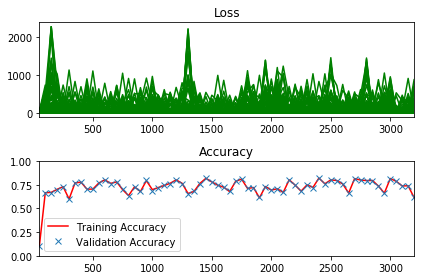

Validation accuracy at 0.7666666507720947


In [23]:
with tf.Session() as session:
    session.run(init)
    batch_count = int(len(train_features)/batch_size)  

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        
loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])

acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'x', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])#y的坐标为【0，1】
acc_plot.set_xlim([batches[0], batches[-1]]) 
#Axes.set_xlim(left=None, right=None, emit=True, auto=False, **kw)
acc_plot.legend(loc='best')      #指定标签位置      
plt.tight_layout()               #两个图画在一起防止标签重叠
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))

In [25]:
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)


assert test_accuracy >= 0.80, 'Test accuracy at {}, should be equal to or greater than 0.80'.format(test_accuracy)
print('Nice Job! Test Accuracy is {}'.format(test_accuracy))

Epoch  2/2: 100%|████████████████████████████████████████████████████████████| 1559/1559 [00:03<00:00, 519.59batches/s]


Nice Job! Test Accuracy is 0.8425999879837036
